# Notebook 3: LSTM Model for Time-Series Detection

## ML-Based Drone Firmware Tampering Detection System

This notebook covers:
- Loading processed data
- Preparing sequences for LSTM
- Building and training LSTM model
- Model evaluation
- Hyperparameter tuning
- Saving trained model


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.18.0


In [ ]:
# Load processed data
DATA_DIR = Path('../data')
X_train = pd.read_csv(DATA_DIR / 'X_train.csv').values
X_test = pd.read_csv(DATA_DIR / 'X_test.csv').values
y_train = pd.read_csv(DATA_DIR / 'y_train.csv').values.ravel()
y_test = pd.read_csv(DATA_DIR / 'y_test.csv').values.ravel()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Test labels: {y_test.shape}")


Training set: (1600, 30)
Test set: (400, 30)
Training labels: (1600,)
Test labels: (400,)


In [ ]:
# Prepare sequences for LSTM
# Since we don't have time-series data, we'll create sequences by sliding window
# or reshape features into sequences

def create_sequences(data, sequence_length=10):
    """
    Create sequences from feature data for LSTM input
    """
    sequences = []
    n_features = data.shape[1]
    
    # Reshape data into sequences
    # Each sample becomes a sequence of sequence_length timesteps
    for i in range(len(data)):
        # Repeat the sample to create a sequence
        sample = data[i]
        sequence = np.tile(sample, (sequence_length, 1))
        sequences.append(sequence)
    
    return np.array(sequences)

# Create sequences
sequence_length = 10
X_train_seq = create_sequences(X_train, sequence_length)
X_test_seq = create_sequences(X_test, sequence_length)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")
print(f"Sequence length: {sequence_length}")
print(f"Features per timestep: {X_train_seq.shape[2]}")


Training sequences shape: (1600, 10, 30)
Test sequences shape: (400, 10, 30)
Sequence length: 10
Features per timestep: 30


In [ ]:
# Build LSTM model
def build_lstm_model(input_shape, num_classes=1):
    """
    Build LSTM model for binary classification
    """
    model = keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),
        layers.LSTM(32, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

# Build model
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
model = build_lstm_model(input_shape)

print("Model architecture:")
model.summary()


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          24,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,281 (145.63 KB)

 Trainable params: 37,281 (145.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=MODELS_DIR / 'lstm_model_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured")


Callbacks configured


In [ ]:
# Train the model
print("Training LSTM model...")
print("=" * 50)

history = model.fit(
    X_train_seq, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test_seq, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


Training LSTM model...
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8753 - loss: 0.4635 - precision: 0.9428 - recall: 0.8098
Epoch 1: val_loss improved from inf to 0.02045, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8769 - loss: 0.4599 - precision: 0.9437 - recall: 0.8122 - val_accuracy: 1.0000 - val_loss: 0.0204 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0254 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_loss improved from 0.02045 to 0.00242, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 0.0251 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0024 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0092 - precision: 1.0000 - recall: 1.0000
Epoch 3: val_loss improved from 0.00242 to 0.00079, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 0.0091 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 7.9139e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0037 - precision: 1.0000 - recall: 1.0000 
Epoch 4: val_loss improved from 0.00079 to 0.00037, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 0.0037 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.7151e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0030 - precision: 1.0000 - recall: 1.0000
Epoch 5: val_loss improved from 0.00037 to 0.00018, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 0.0030 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.7939e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0017 - precision: 1.0000 - recall: 1.0000 
Epoch 6: val_loss improved from 0.00018 to 0.00010, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 0.0017 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.0165e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0018 - precision: 1.0000 - recall: 1.0000    
Epoch 7: val_loss improved from 0.00010 to 0.00006, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 1.0000 - loss: 0.0018 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 6.3999e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 8/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.5820e-04 - precision: 1.0000 - recall: 1.0000
Epoch 8: val_loss improved from 0.00006 to 0.00004, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 7.4793e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.3857e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 9/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 8.2940e-04 - precision: 1.0000 - recall: 1.0000
Epoch 9: val_loss improved from 0.00004 to 0.00003, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 8.3285e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.0032e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 10/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.0793e-04 - precision: 1.0000 - recall: 1.0000
Epoch 10: val_loss improved from 0.00003 to 0.00002, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 5.1134e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.1832e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3510e-04 - precision: 1.0000 - recall: 1.0000
Epoch 11: val_loss improved from 0.00002 to 0.00002, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 3.3611e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.6844e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.6545e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 12: val_loss improved from 0.00002 to 0.00001, saving model to ..\models\lstm_model_best.h5



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 3.6493e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.2980e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 13/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.8570e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 13: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 2.8468e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.1672e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 14/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.2570e-04 - precision: 1.0000 - recall: 1.0000
Epoch 14: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 3.2710e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.0277e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.0696e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 15: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 3.0619e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 9.1107e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 16/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.3886e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 16: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 2.4053e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 8.1210e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 17/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 6.0857e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 17: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.0000 - loss: 6.0414e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 7.1675e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 18/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.8852e-04 - precision: 1.0000 - recall: 1.0000
Epoch 18: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 2.8814e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 6.7250e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 19/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.1157e-04 - precision: 1.0000 - recall: 1.0000
Epoch 19: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 2.1161e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 6.3762e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 20/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.2003e-04 - precision: 1.0000 - recall: 1.0000
Epoch 20: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 6.0842e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.9510e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 21/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.2690e-04 - precision: 1.0000 - recall: 1.0000
Epoch 21: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 2.3045e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.5806e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 22/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.0335e-04 - precision: 1.0000 - recall: 1.0000
Epoch 22: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 2.0196e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.2606e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 23/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.7298e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 23: val_loss improved from 0.00001 to 0.00001, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 2.7274e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.0767e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 24/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.8257e-04 - precision: 1.0000 - recall: 1.0000
Epoch 24: val_loss improved from 0.00001 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 3.8267e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.8745e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 25/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.8443e-04 - precision: 1.0000 - recall: 1.0000
Epoch 25: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 3.8682e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.6640e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 26/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.1693e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 26: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 3.1155e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.4984e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 27/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.2923e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 27: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5



Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 2.2861e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.3618e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 28/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.8484e-04 - precision: 1.0000 - recall: 1.0000
Epoch 28: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 1.8450e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.2836e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 6.2500e-05
Epoch 29/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.6668e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 29: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 2.6528e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.2126e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 6.2500e-05
Epoch 30/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 3.0629e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 30: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 3.1050e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.1300e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 6.2500e-05
Epoch 31/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.6103e-04 - precision: 1.0000 - recall: 1.0000
Epoch 31: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 1.6074e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.0631e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 6.2500e-05
Epoch 32/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.8106e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 32: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5



Epoch 32: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 1.8093e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.9914e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 6.2500e-05
Epoch 33/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.3643e-04 - precision: 1.0000 - recall: 1.0000
Epoch 33: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 2.3553e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.9483e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.1250e-05
Epoch 34/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.0692e-04 - precision: 1.0000 - recall: 1.0000
Epoch 34: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 2.0586e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.9072e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.1250e-05
Epoch 35/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3233e-04 - precision: 1.0000 - recall: 1.0000
Epoch 35: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 1.3648e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.8739e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.1250e-05
Epoch 36/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.6665e-04 - precision: 1.0000 - recall: 1.0000
Epoch 36: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 2.6535e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.8306e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.1250e-05
Epoch 37/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.3214e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 37: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5



Epoch 37: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 3.3255e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.7833e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.1250e-05
Epoch 38/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.2043e-04 - precision: 1.0000 - recall: 1.0000
Epoch 38: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 1.2330e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.7655e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.5625e-05
Epoch 39/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.9930e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 39: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 2.0035e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.7494e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.5625e-05
Epoch 40/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.7479e-04 - precision: 1.0000 - recall: 1.0000
Epoch 40: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 1.7471e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.7267e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.5625e-05
Epoch 41/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.2175e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 41: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 3.2040e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.7063e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.5625e-05
Epoch 42/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.5916e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 42: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5



Epoch 42: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 1.5873e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.6860e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.5625e-05
Epoch 43/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.0602e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 43: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 2.0468e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.6745e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 7.8125e-06
Epoch 44/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.1616e-04 - precision: 1.0000 - recall: 1.0000
Epoch 44: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 4.1402e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.6631e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 7.8125e-06
Epoch 45/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 2.9243e-04 - precision: 1.0000 - recall: 1.0000
Epoch 45: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 2.8782e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.6515e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 7.8125e-06
Epoch 46/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.5294e-04 - precision: 1.0000 - recall: 1.0000
Epoch 46: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 1.5919e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.6395e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 7.8125e-06
Epoch 47/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.0040e-04 - precision: 1.0000 - recall: 1.0000
Epoch 47: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5



Epoch 47: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 1.9835e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.6269e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 7.8125e-06
Epoch 48/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.5908e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 48: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 1.6062e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.6207e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.9063e-06
Epoch 49/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.9012e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 49: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 1.9022e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.6130e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.9063e-06
Epoch 50/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.3301e-04 - precision: 1.0000 - recall: 1.0000 
Epoch 50: val_loss improved from 0.00000 to 0.00000, saving model to ..\models\lstm_model_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 1.3309e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.6078e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.9063e-06
Restoring model weights from the end of the best epoch: 50.

Training completed!


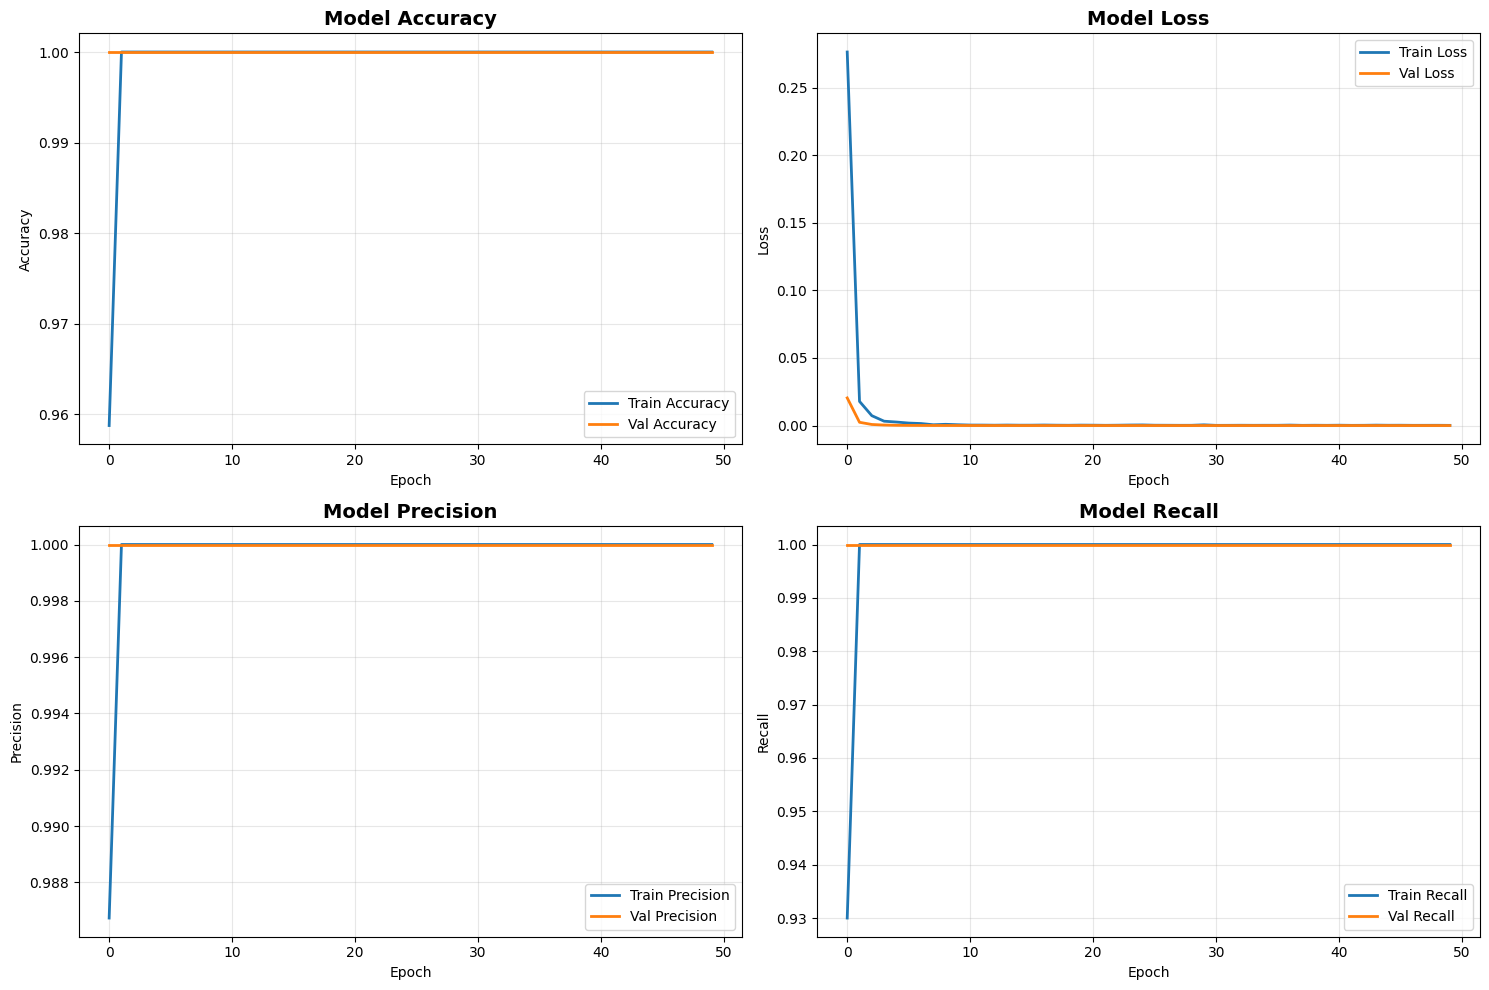

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Evaluate the model
print("Evaluating LSTM model...")
print("=" * 50)

# Load best model
model.load_weights(MODELS_DIR / 'lstm_model_best.h5')

# Predictions
y_pred_proba = model.predict(X_test_seq, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).ravel()

# Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Tampered', 'Clean']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")


Evaluating LSTM model...

Classification Report:
              precision    recall  f1-score   support

    Tampered       1.00      1.00      1.00       200
       Clean       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Confusion Matrix:
[[200   0]
 [  0 200]]

ROC AUC Score: 1.0000


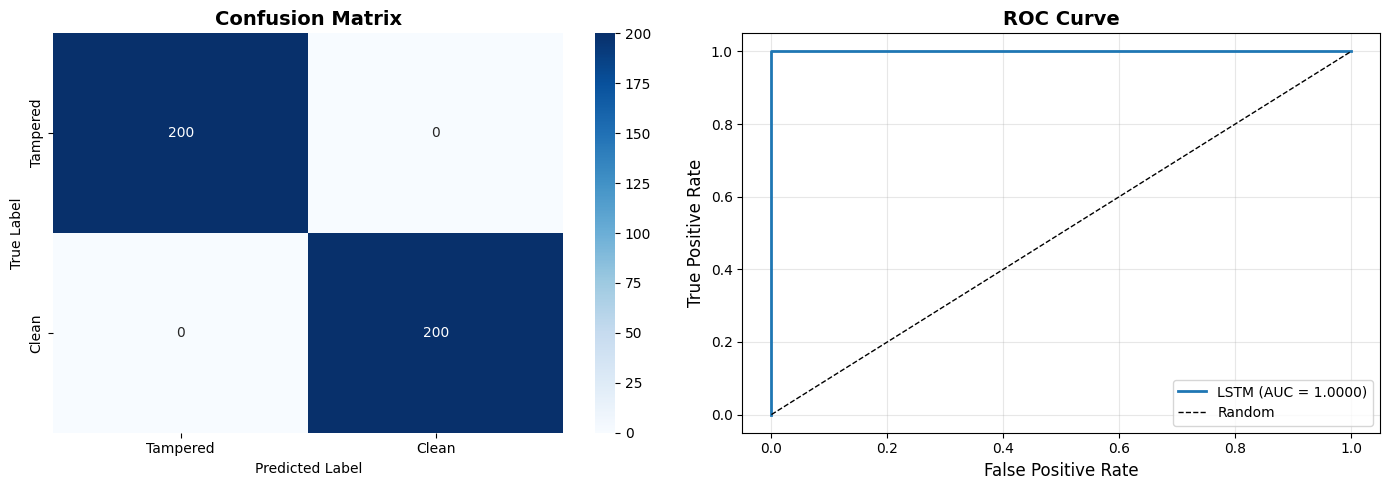

In [ ]:
# Visualize confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Tampered', 'Clean'],
            yticklabels=['Tampered', 'Clean'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'LSTM (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/lstm_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Save final model and results
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

# Save model
model.save(MODELS_DIR / 'lstm_model_final.h5')
print(f"Model saved to {MODELS_DIR / 'lstm_model_final.h5'}")

# Save predictions and probabilities
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'y_pred_proba': y_pred_proba.ravel()
})
results_df.to_csv(RESULTS_DIR / 'lstm_predictions.csv', index=False)
print(f"Predictions saved to {RESULTS_DIR / 'lstm_predictions.csv'}")

# Save model summary (use UTF-8 encoding to handle Unicode characters)
with open(RESULTS_DIR / 'lstm_model_summary.txt', 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f"Model summary saved to {RESULTS_DIR / 'lstm_model_summary.txt'}")

print("\nLSTM model training and evaluation completed!")


Model saved to ..\models\lstm_model_final.h5
Predictions saved to ..\results\lstm_predictions.csv


Model summary saved to ..\results\lstm_model_summary.txt

LSTM model training and evaluation completed!
